# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- l-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 25 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Yuqing"
ln1 = "WANG"
fn2 = "Zhengkang"
ln2 = "SHI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_wang_yuqing_and_shi_zhengkang.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

In [3]:
#from tqdm import tqdm_notebook as tqdm
import time

Now import the necessary function from the optim_utils.py file.

In [4]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [5]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


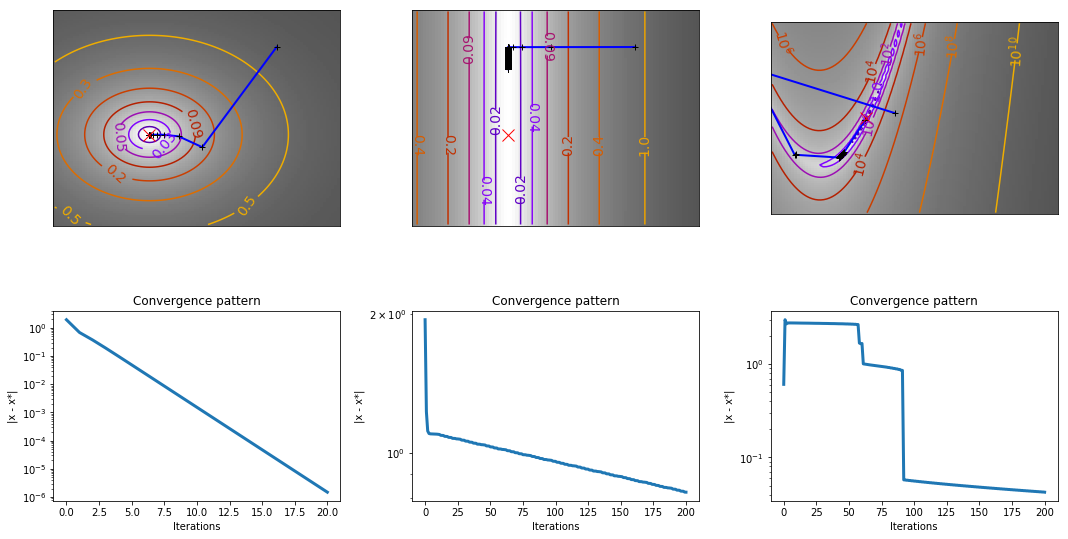

In [6]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 2: Implement Newton method

Implement Newton's method. Beware that the Hessian SHOULD be regularized !

**You are expected to comment** what you see. Play with the parameters. Do not describe the curves, rather

In [7]:
from scipy import linalg
from scipy.sparse.linalg import cg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001  # regularization threshold
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose =True  #False #True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO H = ..
        #'''
        I = [[lambda_threshold, 0], [0 ,lambda_threshold]]
        H = f_hessian(x)
        while linalg.eig(H)[0][0]<=lambda_threshold or linalg.eig(H)[0][1]<=lambda_threshold:
            H += I
        #d = -linalg.inv(H).dot(grad_x)
        d = -linalg.solve(H, grad_x)
        
        '''
        H = f_hessian(x) + lambda_threshold*np.eye(np.shape(x)[0])
        d = -np.linalg.solve(H,np.dot(H,x) - grad_x)
        '''
      
        
             
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))
        

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.447074, l_inf_norm(grad): 0.536361
iter: 2, f: 0.0275414, l_inf_norm(grad): 0.217485
iter: 3, f: 0.0209709, l_inf_norm(grad): 0.199536
iter: 4, f: 0.0177475, l_inf_norm(grad): 0.184019
iter: 5, f: 0.0152203, l_inf_norm(grad): 0.170742
iter: 6, f: 0.0131886, l_inf_norm(grad): 0.159185
iter: 7, f: 0.0115233, l_inf_norm(grad): 0.148984
iter: 8, f: 0.0101368, l_inf_norm(grad): 0.139881
iter: 9, f: 0.00896749, l_inf_norm(grad): 0.131683
iter: 10, f: 0.0079708, l_inf_norm(grad): 0.124243
iter: 11, f: 0.00711357, l_inf_norm(grad): 0.117448
iter: 12, f: 0.0063706, l_inf_norm(grad): 0.111208
iter: 13, f: 0.0057224, l_inf_norm(grad): 0.10545
iter: 14, f: 0.00515364, l_inf_norm(grad): 0.100116
iter: 15, f: 1.94844e-13, l_inf_norm(grad): 6.17984e-07

Running solver on case 2
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_inf_norm(grad): 14.6168
iter: 3, f: 0.137976, l_inf_n

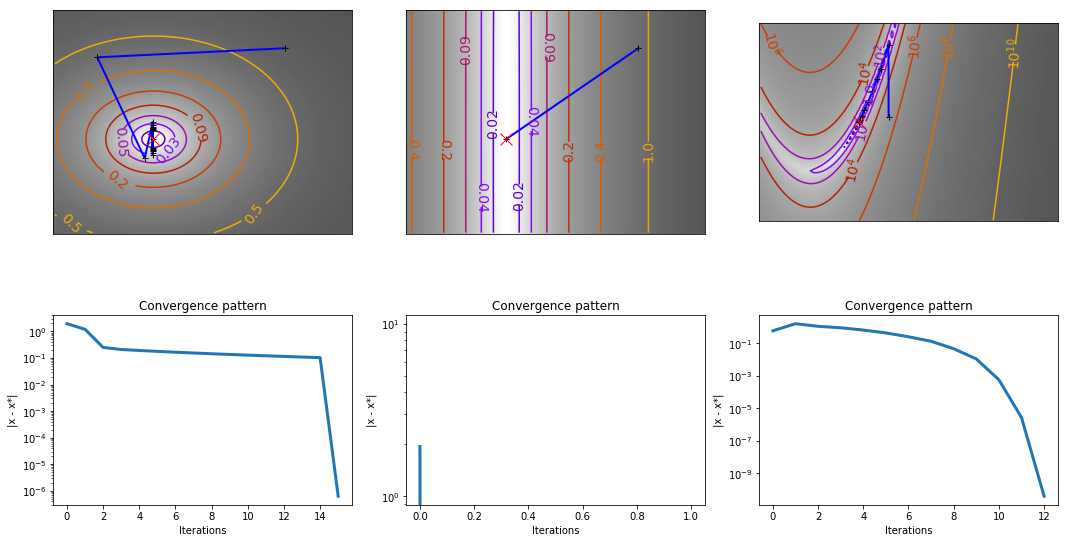

In [8]:
test_solver(newton)

We illustate the methods with three functions:
- a quadratic function, 
- a gaussian function,
- a Rosenbrock function (the global minimum is inside a long, narrow, parabolic shaped flat valley).


#### Comparaison of the Newton method:

- Quadratic case:

For both approaches, we observe that the Newton algorithm converges in 15 iteration.
- Gaussian case: 

Since the gaussian case is the exponential of a quadratic function, we observed: the algorithm converges in one iteration. However, with the conjugate gradient the minimum is just approximated (it may be because of the round-off error related to the conjugate gradient method) 

- Rosenbrock case: 

The convergence is reached with 12 iterations (this function is more difficult to minimize due to the "valley"). 


**COMMENTS HERE**

- We observe that the Newton method converges in 15 steps for the 1st and one step for the 2nd examples. Indeed, these two functions are quadratic (according to the representation of the functions and the code in optim_utils). We know that the Newton method converges independently of the choice of $x_0$ in the case of a quadratic function defined with a symmetric matrix. 
- For the 3rd case, the Rosenbrock function is difficult to optimize (not quadratic and ill-conditioned), but we see that the algorithm converges to the "white region" where the minimum lies, in 12 iterations. 
- Near flat portions of a function both  d/dx and d^2/dx^2 are both nearly zero valued. This can cause serious numerical problems since once each (but especially the denominator) shrinks below machine precision the computer interprets ≈0/0 .One simple and common way to avoid this potential disaster is to simply add a small positive value  ϵ  to the second derivative - either when it shrinks below a certain value or for all iterations.The value of the regularization parameter  ϵ  is set by hand to a small positive value (e.g.in our question:lambda_threshold). Note this is an adjustment made when the function being minimized is known to be convex. The analogous adjustment for the multi-input case is to add  lambda_threshold * IN×N  - a  N×N  identity matrix scaled by a small positive  lambda_threshold  value - to the Hessian matrix. This gives the completely analogous regularized Newton's step for the multi-input case. Note here that since again the function being minimized is assumed to be convex, adding this to the Hessian means to garantee the matrix is always invertible
- Comparison of the Newton and the gradient descent methods: We observe that the Newton algorithm requires fewer iterations to converge than the gradient descent. For example, for the quadratic case, the gradient descent algorithm needs 20 iterations. In addition, for the gaussian and rosenbrock functions, the minimizer is not reached after 200 iterations. More precisely, in the case of the gaussian function, the gradient does not point in the direction of the minimum. In the case of the Rosenbrock function, the gradient descent is zig-zagging, while the Newton algorithm does not "miss" the valey since it takes into account the Hessian (i.e. the curvature of the function). The newton algorithm requires fewer iterations because it has a quadratic convergence (against a linear one for the gradient descent).

# Part 2: Implement DFP algorithm

Now, implement the DFP algorithm using the formula for $B$ in the slides.

**Comment on what you observe**. Focus on the explanation, not on describing the curves! 

Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?

In [9]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        
        # TODO B = ...
        aux1 = s.reshape(-1, 1).dot(s.reshape(1,-1)) / s.reshape(1,-1).dot(y.reshape(-1,1))
        aux2 = B.dot(y.reshape(-1,1).dot(y.reshape(1,-1).dot(B))) / y.reshape(1,-1).dot(B.dot(y.reshape(-1,1))) 
        B += aux1 - aux2
        
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.116073, l_inf_norm(grad): 0.294954
iter: 2, f: 0.10486, l_inf_norm(grad): 0.39697
iter: 3, f: 0.04685, l_inf_norm(grad): 0.217962
iter: 4, f: 0.0138069, l_inf_norm(grad): 0.115525
iter: 5, f: 0.00437215, l_inf_norm(grad): 0.064156
iter: 6, f: 0.000253691, l_inf_norm(grad): 0.0202653
iter: 7, f: 1.91093e-05, l_inf_norm(grad): 0.00611853
iter: 8, f: 8.99248e-08, l_inf_norm(grad): 0.000250249
iter: 9, f: 5.33545e-10, l_inf_norm(grad): 2.30825e-05
iter: 10, f: 1.44662e-13, l_inf_norm(grad): 4.3146e-07

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000138677, l_inf_norm(grad): 0.000270594
iter: 4, f: 1.92681e-07, l_inf_norm(grad): 0.000503909
iter: 5, f: 1.4273e-07, l_inf_norm(grad): 0.000433799
iter: 6, f: 3.512e-14, l_inf_norm(grad): 1.6706e-08

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.56575, l_inf_norm(grad):

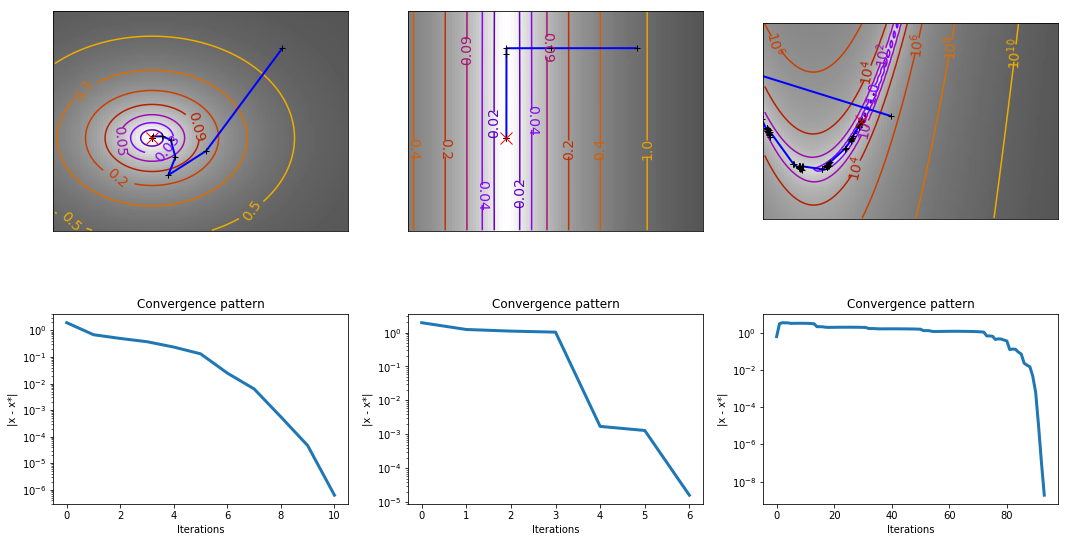

In [10]:
test_solver(dfp)

#### Your comments here

- The DFP method converges for the three cases.
- We can see that for the 2 quadratic functions, DFP converges in more than 2 iterations because we use inexact line search with Wolfe's rule, which is more cost effective than exact line search; but convergence is still achieved in a small number of iterations in the quadratic case.
- The algorithm converges now in 10, 6 and 93 iterations for, respectively, the quadractic, gaussian and rosenbrock functions. The number of iterations has increased (compared to the previous Newton method) since the conditioning of $B.A$ is larger (with $B$ the approximation of the inverse hessian and $A$ the hessian). The approximation of $A$ may be less acurate because of the "correction" and consequently the search directions may be less good.
- The contradiction lies on that we have learned that the convergence speed for the DFP algorithm is n iterations, where n is the dimension of x. For the two first functions, the dimension of x is 2 but the convergence speed is not 2. This is linked to the fact that we use a line search function to update the step size $\rho_k$, which is an estimation of the optimal step size seen in the DFP algorithm theorem.

# Part 3: Implement BFGS algorithm

You should now implement BFGS, using the formula for $B_t$ seen in the slides.

**Comment** on what you see.

In [11]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        #d = -np.dot(B, grad_x)
        d = linalg.solve(B, - grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        # TODO B = 
        #ro = 1 / y.reshape(1, -1).dot(s.reshape(-1,1))
        #aux1 = np.eye(len(x)) - ro * s.reshape(-1,1).dot(y.reshape(1, -1))
        #aux2 = np.eye(len(x)) - ro * y.reshape(-1,1).dot(s.reshape(1, -1))
        #B = aux1.dot(B.dot(aux2)) + ro * s.reshape(-1,1).dot(s.reshape(1, -1))
        
        
        B += np.outer(y, y) / np.dot(y, s) - np.dot(np.dot(B, np.outer(s, s)), B) / np.dot(s, np.dot(B, s))
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.116073, l_inf_norm(grad): 0.294954
iter: 2, f: 0.0715972, l_inf_norm(grad): 0.298126
iter: 3, f: 0.000284747, l_inf_norm(grad): 0.0142191
iter: 4, f: 4.52613e-06, l_inf_norm(grad): 0.00176864
iter: 5, f: 9.79602e-11, l_inf_norm(grad): 1.20082e-05
iter: 6, f: 5.7665e-13, l_inf_norm(grad): 8.52445e-07

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000119306, l_inf_norm(grad): 0.00025098
iter: 4, f: 6.91982e-13, l_inf_norm(grad): 9.54949e-07

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.59071, l_inf_norm(grad): 26.034
iter: 3, f: 7.34411, l_inf_norm(grad): 4.87129
iter: 4, f: 7.29555, l_inf_norm(grad): 8.30631
iter: 5, f: 6.98403, l_inf_norm(grad): 49.3631
iter: 6, f: 6.72314, l_inf_norm(grad): 26.9831
iter: 7, f: 6.31556, l_inf_norm(grad): 14.5499
iter: 8, f: 5.59349, l_inf_norm(grad): 26.8298
iter: 9, f: 5.29311

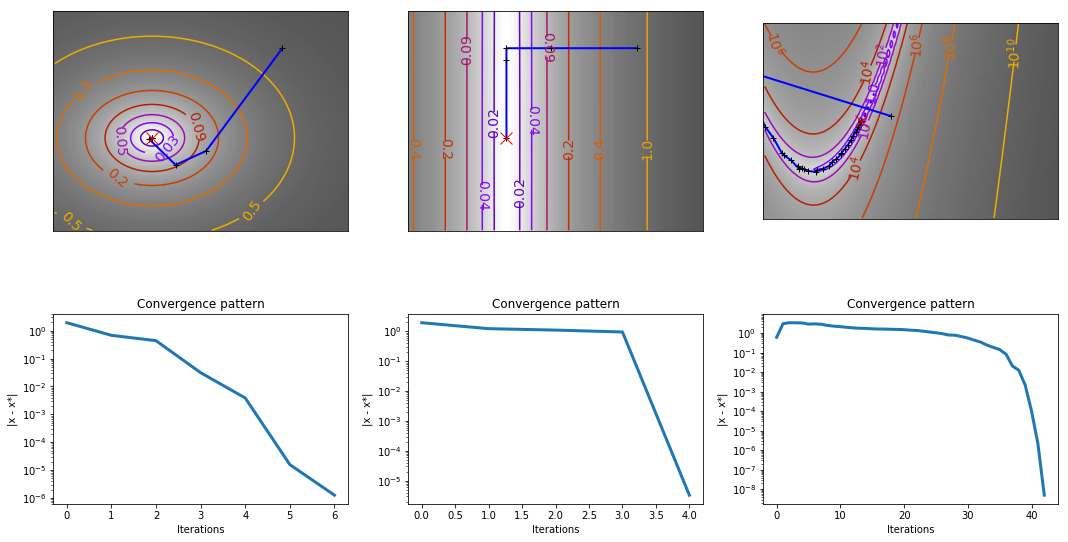

In [12]:
test_solver(bfgs)

#### Your comments here

#### Comments for BFGS:

- The convergence for BFGS is similar to the DFP one: we see that the iterates follow the similiar path according to the schemas. However, BFGS is faster in term of number of iterations ( for the Rosenbrock minimization, 42 iterations for BFGS versus 93 for the DFP).  It is due to the fact that the BFGS algorithm is less sensitive than DFP to the use of approximate step size.<br>
- In fact, DFP and BFGS formulas are dual for each other. In this case, solving the BFGS problem was easier than solving the DFP one (which is its dual formulation). 
- Note that the DFP and BGFS algorithms have quite similar performance concerning quadratic functions.

# Part 3: Implement l-BFGS algorithm

You should now implement the l-BFGS algorithm. First, code the two-loops recursion:

In [13]:
def two_loops(grad_x, m, s_list, y_list, rho_list, B0):
    '''
    Parameters
    ----------
    
    grad_x : ndarray, shape (p,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    rho_list : list of length m
        the past m values of rho
        
    B0 : ndarray, shape (p, p)
        Initial inverse Hessian guess
    
    Returns
    -------
    
    r :  ndarray, shape (p,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    # TODO : first loop
    
    #for i in range(n,n-m-1,-1):
    
    l=len(y_list)
    #for i in range(m):
    for i in range(l):
        # t 4->0 
        t = l-i-1
        
        pt = 1 / np.dot(y_list[t].T, s_list[t])
        alpha_list.append(pt*np.dot(s_list[t].T, q))

        q = q - alpha_list[i] * y_list[t]
    
    
    r = np.dot(B0, q)
    # TODO: second loop
    
    for i in range(l):
        t = l - i - 1
        #pi = 1 / (np.dot(y_list[i].T, s_list[i])[0, 0])
        pi = 1 / (np.dot(y_list[i].T, s_list[i]))
        beta = pi*np.dot(y_list[i].T, r)
        #z = z + s_list[i]*(alpha_list[t] - beta)
        r = r + s_list[i]*(alpha_list[t] - beta)
    
    return -r



In [14]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, rho_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, rho_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        rho = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        rho_list.append(rho)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            rho_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.116073, l_inf_norm(grad): 0.294954
iter: 2, f: 0.0715972, l_inf_norm(grad): 0.298126
iter: 3, f: 0.000284747, l_inf_norm(grad): 0.0142191
iter: 4, f: 4.52613e-06, l_inf_norm(grad): 0.00176864
iter: 5, f: 9.36522e-11, l_inf_norm(grad): 1.17494e-05
iter: 6, f: 2.41285e-12, l_inf_norm(grad): 1.7439e-06
iter: 7, f: 0, l_inf_norm(grad): 7.35661e-10

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000119306, l_inf_norm(grad): 0.00025098
iter: 4, f: 6.91982e-13, l_inf_norm(grad): 9.54949e-07

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.59071, l_inf_norm(grad): 26.034
iter: 3, f: 7.34411, l_inf_norm(grad): 4.87129
iter: 4, f: 6.45494, l_inf_norm(grad): 36.8967
iter: 5, f: 6.01768, l_inf_norm(grad): 37.5477
iter: 6, f: 5.32463, l_inf_norm(grad): 17.1147
iter: 7, f: 4.34469, l_inf_norm(grad): 23.2154
iter: 8, f: 4.14823, 

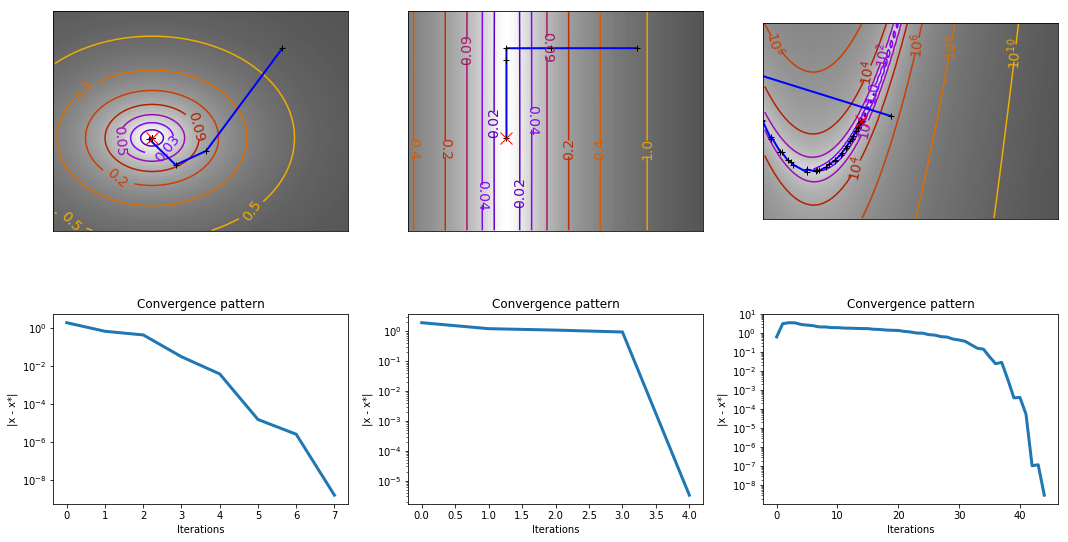

In [15]:
test_solver(lbfgs)

**Comment on what you observe**

- The L-BFGS and BFGS algorithms converge with aproximately the same number of iterations for the three functions.And we see that the iterates follow the totally same path according to the schemas
- For all three cases, L-BFGS is very efficient. It is impressive for the Rosenbrock function minimization, particularly when we compare it to previously seen algorithms(except for BFGS) : it's fast and in the same time, efficient. After a few iteration, the L-BFGS algorithm is already very close to the solution. <br>
- L-BFGS will not be faster than BFGS on a single machine, which is for sure. However, the L-BFGS's two loop recursion algorithm has been specially adapted for parallelization.L-BFGS is less memory-demanding which makes it faster.
- In the previous BFGS algorithm, we could store the curvature information of the most recent iteration without storing the matrix. When an iteration is completed, the information of the oldest curvature will be deleted, and the latest curvature will be saved, so this ensures that the saved curvature information will always come from the most recent iteration.